#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [78]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from time import time

In [8]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

def pairwise(iterable):
  a = iter(iterable)
  return zip(a, a)

In [85]:
class Chromosome:
  def __init__(self, length, array=None): #if array is None it should be initialized with random binary vector
    if array is None:
      self._array = np.random.randint(2, size=length)
    else:
      self._array = array
    self._length = length

  def decode(self, lower_bound: int, upper_bound: int, aoi: Tuple[float, float]) -> float:
      bits = upper_bound - lower_bound
      encoded_value = 0
      for i in range(bits):
        encoded_value += self._array[lower_bound+i]*pow(2, bits-i-1)
      return min_max_norm(encoded_value, 0, pow(2, bits), *aoi)

  def mutation(self, probability: float) -> None:
    if np.random.uniform(0, 1) < probability:
      gene_index = np.random.randint(0, self._length)
      self._array[gene_index] = int(not(self._array[gene_index]))

  def crossover(self, other: 'Chromosome') -> Tuple['Chromosome', 'Chromosome']:
    assert self._length == other._length

    crossover_index = np.random.randint(0, self._length)
    first_chromosome_array = np.empty((self._length, 1))
    second_chromosome_array = np.empty((self._length, 1))

    for i in range(crossover_index):
      first_chromosome_array[i] = self._array[i]
      second_chromosome_array[i] = other._array[i]

    for i in range(crossover_index, self._length):
      first_chromosome_array[i] = other._array[i]
      second_chromosome_array[i] = self._array[i]

    child1 = Chromosome(self._length, first_chromosome_array)
    child2 = Chromosome(self._length, second_chromosome_array)
    return child1, child2

In [80]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
    
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self._chromosome_lengths = chromosome_length
    self._obj_func_num_args = obj_func_num_args
    self._bits_per_arg = int(chromosome_length / obj_func_num_args)
    self._objective_function = objective_function
    self._aoi = aoi
    self._tournament_size = tournament_size
    self._mutation_probability = mutation_probability
    self._crossover_probability = crossover_probability
    self._num_steps = num_steps
    self._population_size = population_size
    
    self._best_chromosomes = []
    self._trace = []
      
  @property
  def trace(self):
    return self._trace
  
  @property
  def best_chromosomes(self):
    return self._best_chromosomes

  def retrieve_obj_func_args(self, chromosome: 'Chromosome') -> np.ndarray[float]:
    arguments = []
    for i in range(self._obj_func_num_args):
      value = float(chromosome.decode(i*self._bits_per_arg, (i+1)*self._bits_per_arg, self._aoi))
      arguments.append(value)
    return np.array(arguments)

  def eval_objective_func(self, chromosome: 'Chromosome') -> float:
    return self._objective_function(*self.retrieve_obj_func_args(chromosome))

  def tournament_selection_step(self, population: np.ndarray['Chromosome']) -> 'Chromosome':
    chosen_individuals = np.random.choice(population, self._tournament_size)
    evaluations = [self.eval_objective_func(individual) for individual in chosen_individuals]
    winner = evaluations.index(min(evaluations))
    return chosen_individuals[winner]
  
  def tournament_selection(self, population: np.ndarray['Chromosome']) -> np.ndarray['Chromosome']:
    temporary_generation = []
    while len(temporary_generation) < self._population_size:
      # Select individuals to temporary generation using tournament selection and add them to the temporary generation
      temporary_generation.append(self.tournament_selection_step(population))
    return np.array(temporary_generation)

  def reproduce(self, population: np.ndarray['Chromosome']) -> np.ndarray['Chromosome']:
    # Select individuals from current population using tournament selection
    return self.tournament_selection(population)
  
  def crossover_and_mutate(self, population: np.ndarray['Chromosome']) -> np.ndarray['Chromosome']:
    new_generation = []
    
    for parent1, parent2 in pairwise(population):
      # Crossover parents with given probability, otherwise move them to the next generation
      if np.random.uniform(0, 1) < self._crossover_probability:
        child1, child2 = parent1.crossover(parent2)
        new_generation += [child1, child2]
      else:
        new_generation += [parent1, parent2]

    # Mutate new generation with given probability
    for individual in new_generation:
      individual.mutation(self._mutation_probability)

    return np.array(new_generation)

  def find_best(self, population, evaluations) -> Tuple['Chromosome', float]:
    best_evaluation = min(evaluations)
    best_evaluation_index = evaluations.index(best_evaluation)
    best_individual = population[best_evaluation_index]
    return best_individual, best_evaluation

  def plot_func(self, trace: np.array, x_range: np.ndarray=None, y_range: np.ndarray=None) -> None:
    if x_range is None:
      X = np.arange(-1, 1, 0.05)
    else:
      X = x_range
    
    if y_range is None:
      Y = np.arange(-1, 1, 0.05)
    else:
      Y = y_range
    
    X, Y = np.meshgrid(X, Y)
    Z = self._objective_function(X, Y)
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

  def run(self, optimum_arguments=None, verbose=0, plot=False, plot_ranges=None) -> None:
    # Initialize the population and then evaluate it
    population = [Chromosome(self._chromosome_lengths) for _ in range(self._population_size)]
    evaluations = [self.eval_objective_func(individual) for individual in population]
    
    # Select best individual and return it with its evaluation
    best_individual, best_evaluation = self.find_best(population, evaluations)
    
    # Initialize trace with best individual
    self._trace = []
    self._trace.append(self.retrieve_obj_func_args(best_individual))
    self._best_chromosomes.append({'chromosome': best_individual, 'arguments': self.retrieve_obj_func_args(best_individual), 'obj_func_value': best_evaluation})
    if verbose != 0:
      if optimum_arguments is None:
        print(f"Initial best individual parameters:\tArguments: {np.array2string(self.retrieve_obj_func_args(best_individual), precision=3, floatmode='fixed')}\tEval: {self.eval_objective_func(best_individual): .3e}")
      else:
        print(f"Initial best individual parameters:\tArguments: {np.array2string(self.retrieve_obj_func_args(best_individual), precision=3, floatmode='fixed')}\tEval: {self.eval_objective_func(best_individual): .3e}\tError: {abs(self._objective_function(*optimum_arguments) - self.eval_objective_func(best_individual)): .3e}")
    
    for i in range(self._num_steps):
      start_time = time()
      # Reproduction step, returning temporary generation
      temporary_generation = self.reproduce(population)
      
      # Crossover and mutate the temporary generation
      mutants = self.crossover_and_mutate(temporary_generation)
      
      # Evaluate mutants and select best individual among them
      evaluations = [self.eval_objective_func(individual) for individual in mutants]
      step_best_individual, step_best_evaluation = self.find_best(mutants, evaluations)
      
      if step_best_evaluation <= best_evaluation:
        best_evaluation = step_best_evaluation
        best_individual = step_best_individual
          
      # Update trace with the best individual from current step
      self._trace.append(self.retrieve_obj_func_args(step_best_individual))
      self._best_chromosomes.append({'chromosome': step_best_individual, 'arguments': self.retrieve_obj_func_args(step_best_individual), 'obj_func_value': step_best_evaluation})
      
      # Assign mutant generation as latest generation for next step
      population = mutants
      end_time = time()
      
      if verbose == 1:
        if optimum_arguments is None:
          print(f"Step: {i:<3}\tBest individual parameters:\tArguments: {np.array2string(self.retrieve_obj_func_args(best_individual), precision=3, floatmode='fixed')}\tEval: {self.eval_objective_func(best_individual): .3e}")
        else:
          print(f"Step: {i:<3}\tBest individual parameters:\tArguments: {np.array2string(self.retrieve_obj_func_args(best_individual), precision=3, floatmode='fixed')}\tEval: {self.eval_objective_func(best_individual): .3e}\tError: {abs(self._objective_function(*optimum_arguments) - self.eval_objective_func(best_individual)): .3e}")
      elif verbose == 2:
        if optimum_arguments is None:
          print(f"Step: {i:<3}\tBest individual parameters:\tArguments: {np.array2string(self.retrieve_obj_func_args(best_individual), precision=3, floatmode='fixed')}\tEval: {self.eval_objective_func(best_individual): .3e}\tStep executed in {end_time-start_time:<.4e} [s]")
        else:
          print(f"Step: {i:<3}\tBest individual parameters:\tArguments: {np.array2string(self.retrieve_obj_func_args(best_individual), precision=3, floatmode='fixed')}\tEval: {self.eval_objective_func(best_individual): .3e}\tStep executed in {end_time-start_time:<.4e} [s]\tError: {abs(self._objective_function(*optimum_arguments) - self.eval_objective_func(best_individual)): .3e}")
      

    if plot:
      if plot_ranges is None:
        self.plot_func(self._trace)
      else:
        self.plot_func(self._trace, *plot_ranges)

# Pierwsza funkcja

\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}

In [82]:
f = lambda x, y: 1.5 - np.exp(-x**2-y**2) - 0.5*np.exp(-(x-1)**2-(y+2)**2)
X = np.arange(-2, 3, 0.05)
Y = np.arange(-4, 2, 0.05)

Initial best individual parameters:	Arguments: [0.135 0.187]	Eval:  5.500e-01	Error:  5.340e-02
Step: 0  	Best individual parameters:	Arguments: [-0.009 -0.006]	Eval:  4.967e-01	Step executed in 1.3940e+00 [s]	Error:  1.045e-04
Step: 1  	Best individual parameters:	Arguments: [-0.009 -0.006]	Eval:  4.967e-01	Step executed in 3.2688e-01 [s]	Error:  1.045e-04
Step: 2  	Best individual parameters:	Arguments: [-0.009 -0.631]	Eval:  8.010e-01	Step executed in 3.5215e-01 [s]	Error:  3.044e-01
Step: 3  	Best individual parameters:	Arguments: [ 0.000 -0.007]	Eval:  4.966e-01	Step executed in 3.6026e-01 [s]	Error:  4.943e-05
Step: 4  	Best individual parameters:	Arguments: [ 0.000 -0.007]	Eval:  4.966e-01	Step executed in 3.6148e-01 [s]	Error:  4.943e-05
Step: 5  	Best individual parameters:	Arguments: [ 0.000 -0.007]	Eval:  4.966e-01	Step executed in 3.5834e-01 [s]	Error:  4.943e-05
Step: 6  	Best individual parameters:	Arguments: [ 0.000 -0.007]	Eval:  4.966e-01	Step executed in 3.6145e-01 [s

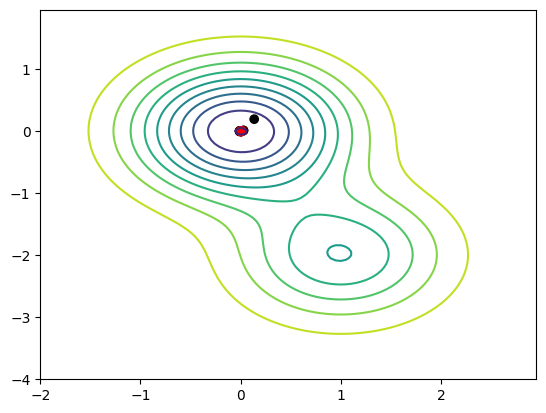

In [92]:
algorithm = GeneticAlgorithm(32, 2, f, [-5, 5], population_size=1000, num_steps=30)
algorithm.run(optimum_arguments=[0, 0], verbose=2, plot=True, plot_ranges=[X, Y])

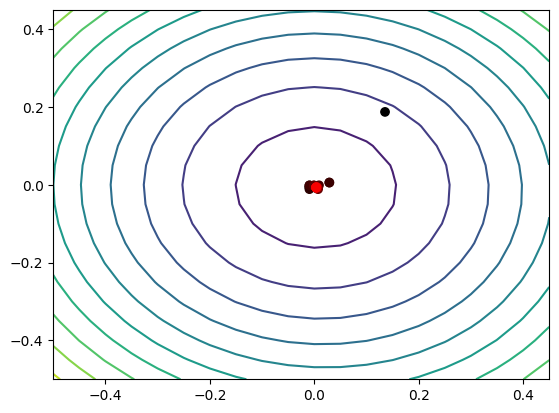

In [93]:
X_narrow = np.arange(-0.5, 0.5, 0.05)
Y_narrow = np.arange(-0.5, 0.5, 0.05)
algorithm.plot_func(algorithm.trace, X_narrow, Y_narrow)

In [65]:
g = lambda x, y: (x + 2*y - 7)**2 + (2*x + y - 5)**2
XG = np.arange(-10, 10, 0.05)
YG = np.arange(-10, 10, 0.05)

In [66]:
g(1, 3)

0

Initial best individual parameters:	Arguments: [0.637 3.109]	Eval:  4.012e-01	Error:  4.012e-01
Step: 0  	Best individual parameters:	Arguments: [1.306 2.914]	Eval:  2.955e-01	Step executed in 1.4183e+00 [s]	Error:  2.955e-01
Step: 1  	Best individual parameters:	Arguments: [0.871 3.255]	Eval:  1.454e-01	Step executed in 4.3211e-01 [s]	Error:  1.454e-01
Step: 2  	Best individual parameters:	Arguments: [0.906 3.097]	Eval:  1.823e-02	Step executed in 4.8222e-01 [s]	Error:  1.823e-02
Step: 3  	Best individual parameters:	Arguments: [0.905 3.065]	Eval:  1.694e-02	Step executed in 4.8823e-01 [s]	Error:  1.694e-02
Step: 4  	Best individual parameters:	Arguments: [0.905 3.065]	Eval:  1.694e-02	Step executed in 4.9383e-01 [s]	Error:  1.694e-02
Step: 5  	Best individual parameters:	Arguments: [0.928 3.056]	Eval:  9.401e-03	Step executed in 4.8859e-01 [s]	Error:  9.401e-03
Step: 6  	Best individual parameters:	Arguments: [0.968 3.055]	Eval:  6.063e-03	Step executed in 4.8535e-01 [s]	Error:  6.06

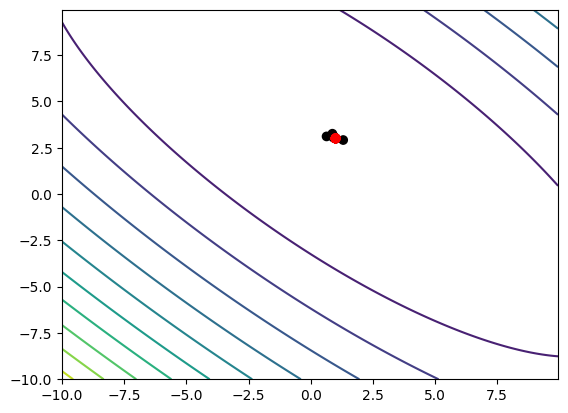

In [94]:
algorithm2 = GeneticAlgorithm(48, 2, g, [-10, 10], population_size=1000, num_steps=100, mutation_probability=0.25)
algorithm2.run(plot=True, optimum_arguments=[1, 3], verbose=2, plot_ranges=[XG, YG])

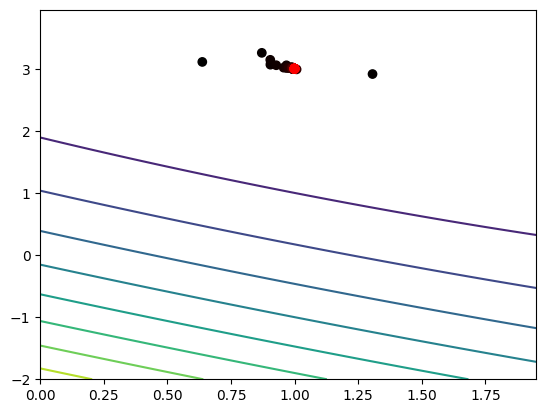

In [95]:
XG_narrow = np.arange(0, 2, 0.05)
YG_narrow = np.arange(-2, 4, 0.05)
algorithm2.plot_func(algorithm2.trace, XG_narrow, YG_narrow)